In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast
import re

In [ ]:
df = pd.read_csv('data_final_fix.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10181 entries, 0 to 10180
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       10181 non-null  object 
 1   course_url      10181 non-null  object 
 2   title           10181 non-null  object 
 3   headline        10178 non-null  object 
 4   is_bestseller   10181 non-null  object 
 5   rating          10181 non-null  float64
 6   num_reviews     10181 non-null  object 
 7   num_students    10181 non-null  object 
 8   instructor      10181 non-null  object 
 9   language        10181 non-null  object 
 10  price           10181 non-null  float64
 11  discount        9831 non-null   object 
 12  related_topics  10181 non-null  object 
 13  sections        10181 non-null  float64
 14  lectures        10181 non-null  float64
 15  total_length    10181 non-null  object 
dtypes: float64(4), object(12)
memory usage: 1.2+ MB


In [6]:
def parse_topics(topics_str):
    """Parses the 'related_topics' string into a list."""
    if not isinstance(topics_str, str) or topics_str == "[]":
        return []
    try:
        if topics_str.startswith('[') and topics_str.endswith(']'):
            parsed_list = ast.literal_eval(topics_str)
            return [str(item).strip() for item in parsed_list]
        else:
            return [topic.strip() for topic in topics_str.split(',')]
    except Exception:
        return []

def clean_numeric(value_str):
    """Removes commas and converts to a number."""
    if not isinstance(value_str, str):
        return 0
    # Remove all non-numeric characters (except the decimal point)
    cleaned_str = re.sub(r"[^0-9.]", "", value_str)
    try:
        return float(cleaned_str)
    except ValueError:
        return 0


In [7]:
df['related_topics'] = df['related_topics'].apply(parse_topics)
df['num_reviews'] = df['num_reviews'].apply(clean_numeric)
df['num_students'] = df['num_students'].apply(clean_numeric)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce').fillna(0)
df['is_bestseller'] = df['is_bestseller'].apply(lambda x: True if x == 'Yes' else False)

df_clean = df[['title', 'related_topics', 'num_reviews', 'num_students', 'rating', 'is_bestseller']]
df_clean

,title,related_topics,num_reviews,num_students,rating,is_bestseller
0,"Machine Learning A-Z: AI, Python & R + ChatGPT...","[Machine Learning, Data Science, Development]",200080.0,1159767.0,4.5,True
1,"Complete Data Science,Machine Learning,DL,NLP ...","[Data Science, Other IT & Software, IT & Softw...",2700.0,107821.0,4.5,True
2,"Complete A.I. & Machine Learning, Data Science...","[Data Science, Development]",28660.0,153392.0,4.6,False
3,Mathematical Foundations of Machine Learning,"[Math, Data Science, Development]",7816.0,137461.0,4.6,True
4,Machine Learning for Absolute Beginners - Level 1,"[Machine Learning, Data Science, Development]",29071.0,115825.0,4.5,False
...,...,...,...,...,...,...
10176,CompTIA A+ Core 1 (220-1101) & Core 2 (220-110...,"[IT Fundamentals, IT Certifications, IT & Soft...",498.0,2704.0,4.5,False
10177,An Introduction to Software Defined Networks (...,"[Software Defined Networking (SDN), Network & ...",10.0,40.0,4.4,False
10178,Part A - Networking Projects - Implement TCP/I...,"[Network Programming, Network & Security, IT &...",226.0,4375.0,4.4,False
10179,Getting Started with Network Simulator 3 (ns-3),"[Network Security, Network & Security, IT & So...",57.0,193.0,4.2,False


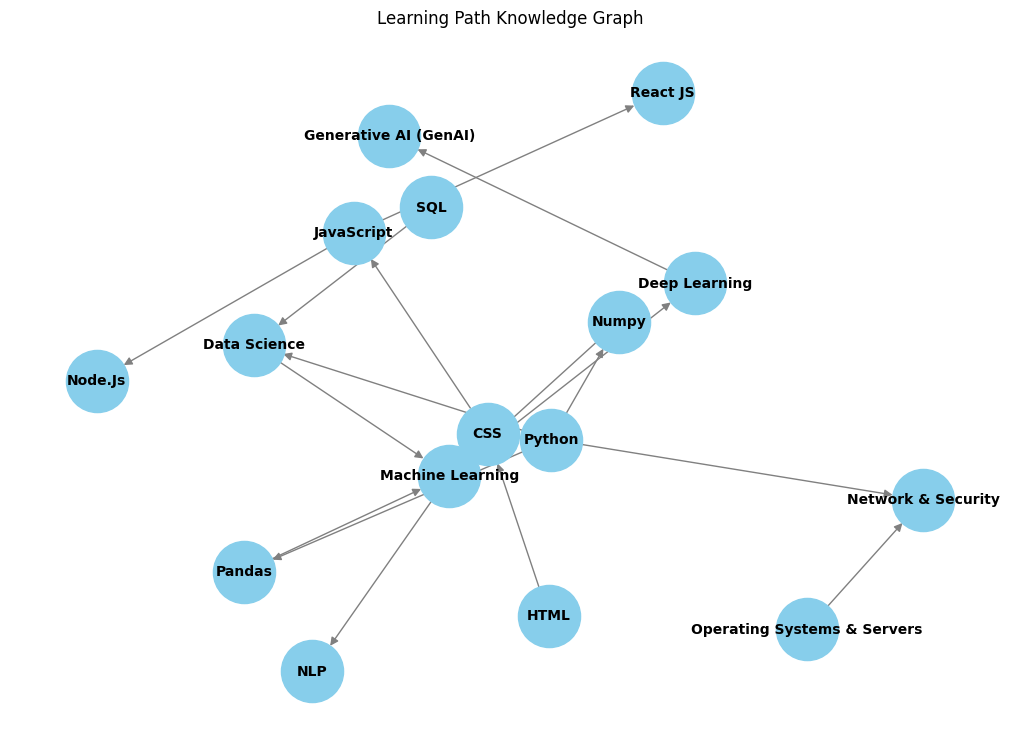

In [8]:
G = nx.DiGraph()

G.add_edges_from([
    ('Python', 'Numpy'),
    ('Python', 'Pandas'),
    ('Python', 'Data Science'),
    ('SQL', 'Data Science'),
    ('Numpy', 'Machine Learning'),
    ('Pandas', 'Machine Learning'),
    ('Data Science', 'Machine Learning'),
    ('Machine Learning', 'Deep Learning'),
    ('Machine Learning', 'NLP'),
    ('Deep Learning', 'Generative AI (GenAI)')
])

G.add_edges_from([
    ('HTML', 'CSS'),
    ('CSS', 'JavaScript'),
    ('JavaScript', 'React JS'),
    ('JavaScript', 'Node.Js')
])

G.add_edges_from([
    ('Operating Systems & Servers', 'Network & Security'),
    ('Python', 'Network & Security')
])

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.8, seed=42) # 'k' adjusts spacing
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000,
        edge_color='gray', font_size=10, font_weight='bold', arrows=True,
        arrowstyle='-|>', arrowsize=12)
plt.title("Learning Path Knowledge Graph")
plt.show()

In [10]:
topic_to_courses = {}
graph_topics = set(G.nodes)

for index, course in df_clean.iterrows():
    course_topics = set(course['related_topics'])
    relevant_topics = graph_topics.intersection(course_topics)

    if relevant_topics:
        course_details = {
            'title': course['title'],
            'rating': course['rating'],
            'students': course['num_students'],
            'is_bestseller': course['is_bestseller']
        }

        for topic in relevant_topics:
            if topic not in topic_to_courses:
                topic_to_courses[topic] = []
            topic_to_courses[topic].append(course_details)

print(f"Mapping complete. {len(topic_to_courses)} topics have courses.")


Mapping complete. 14 topics have courses.


In [16]:
import networkx as nx

def find_complete_logical_path(graph, target_topic):
    """
    Finds the single, complete, logically-ordered path to a target topic.
    """
    if target_topic not in graph:
        return None, f"Topic '{target_topic}' not in our knowledge graph."

    # 1. Find all prerequisites (ancestors)
    # This finds ALL topics needed before you can learn the target
    try:
        prerequisites = nx.ancestors(graph, target_topic)
    except nx.NetworkXError:
        # This happens if the target topic has no prerequisites (it's a root)
        return [target_topic], "Path found (this is a root topic)."

    # 2. Create the complete "curriculum"
    # This set includes the target topic itself + all its prerequisites
    curriculum_nodes = prerequisites.union({target_topic})

    # 3. Create a subgraph containing ONLY these topics
    curriculum_graph = graph.subgraph(curriculum_nodes)

    # 4. Topologically sort the subgraph
    # This gives the single most logical learning order
    # It guarantees all prerequisites come first.
    try:
        logical_path = list(nx.topological_sort(curriculum_graph))
        return logical_path, "Path found."
    except nx.NetworkXUnfeasible:
        return None, "Error: A circular dependency (e.g., A->B and B->A) was detected in the graph."

def recommend_courses(topic, mapper, top_n=2):
    """
    Recommends the top_n best courses for a given topic.
    (This function is unchanged)
    """
    courses = mapper.get(topic, [])

    if not courses:
        return ["  -> No courses found in our catalog for this specific topic."]

    # --- This is our RANKING LOGIC ---
    sorted_courses = sorted(courses,
                            key=lambda x: (x['is_bestseller'], x['rating'], x['students']),
                            reverse=True)

    recommendations = []
    for course in sorted_courses[:top_n]:
        bestseller_tag = " (Bestseller)" if course['is_bestseller'] else ""
        rec_str = (
            f"  * {course['title']}{bestseller_tag}\n"
            f"    (Rating: {course['rating']}, Students: {int(course['students'])})"
        )
        recommendations.append(rec_str)

    return recommendations

print("Recommender helper functions (with new 'find_complete_logical_path') are defined.")

Recommender helper functions (with new 'find_complete_logical_path') are defined.


In [22]:
# --- TWEAK YOUR RECOMMENDATION HERE ---

# 1. What topic do you want to learn?
query_topic = "Machine Learning"


# 2. How many topics (steps) are you willing to learn?
desired_steps = 8


# ----------------------------------------

print(f"Finding the most direct {desired_steps}-step logical path to: '{query_topic}'\n")

# 1. First, find the COMPLETE logical path
complete_path, status = find_complete_logical_path(G, query_topic)

if not complete_path:
    print(status)
else:
    full_path_len = len(complete_path)

    # 2. Handle the "100 courses" problem (the cap)
    if desired_steps > full_path_len:
        print(f"Note: You asked for {desired_steps} steps, but the complete logical path has {full_path_len} steps.")
        print("We will show you the complete path.\n")
        num_steps_to_show = full_path_len
    else:
        num_steps_to_show = desired_steps

    truncated_path = complete_path[-num_steps_to_show:]

    print(f"--- Your {len(truncated_path)}-Step Recommended Path ---")
    print(f"Path: {' -> '.join(truncated_path)}\n")

    for i, topic in enumerate(truncated_path):
        print(f"--- Step {i+1}: Learn {topic} ---")

        recommendations = recommend_courses(topic, topic_to_courses, top_n=3)
        for rec in recommendations:
            print(rec)
        print("")

Finding the most direct 8-step logical path to: 'Machine Learning'

Note: You asked for 8 steps, but the complete logical path has 6 steps.
We will show you the complete path.

--- Your 6-Step Recommended Path ---
Path: Python -> SQL -> Numpy -> Pandas -> Data Science -> Machine Learning

--- Step 1: Learn Python ---
  * Python Foundations: Build Your Programming Base (Bestseller)
    (Rating: 5.0, Students: 1088)
  * Python Fast-Track: Learn Code, Crack Interviews (Bestseller)
    (Rating: 5.0, Students: 1002)
  * 50 Days of Learning 50 Pro Level Python Concepts (Bestseller)
    (Rating: 5.0, Students: 91)

--- Step 2: Learn SQL ---
  * Learn SQL by Doing: 100+ Practical Challenges (Bestseller)
    (Rating: 5.0, Students: 9)
  * The Complete SQL Bootcamp: Go from Zero to Hero (Bestseller)
    (Rating: 4.7, Students: 965862)
  * The Complete SQL Bootcamp (30 Hours): Go from Zero to Hero (Bestseller)
    (Rating: 4.7, Students: 11131)

--- Step 3: Learn Numpy ---
  -> No courses found i